<a href="https://colab.research.google.com/github/Koushikgoud/Stock_Price_Prediction-using-DL/blob/main/Advanced_stock_price_prediction_vGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
import os
from google.colab import drive
import time
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/Datasets/stocksData2022/"

start_time = time.time()

df = pd.read_csv(os.path.join(dataset_path, 'TATAMOTORS_with_indicators_.csv'))

selected_features = ['close', 'sma5', 'sma10', 'sma15', 'sma20', 'ema5', 'ema10', 'ema15', 'ema20']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[selected_features].values)

# Create a separate scaler for the 'close' prices column
close_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = close_scaler.fit_transform(df['close'].values.reshape(-1, 1))


# Split the data into 80% for training and 20% for testing
train_data_len = int(len(scaled_close) * 0.8)
train_data = scaled_close[0:train_data_len, :]
test_data = scaled_close[train_data_len:, :]

x_train = []
y_train = []
for i in range(60, train_data_len):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Build the GRU model
model = Sequential()
model.add(GRU(150, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.5))
model.add(GRU(150, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(150, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(25))
model.add(Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2, callbacks=[early_stopping])


x_test = []
y_test = df['close'][train_data_len:].values
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)

predictions = model.predict(x_test)

# Inverse transform the predictions using the 'close' scaler
predictions = close_scaler.inverse_transform(predictions)
min_length = min(len(predictions), len(y_test))

predictions_trimmed = predictions[:min_length]
y_test_trimmed = y_test[:min_length]

predictions_reshaped = predictions_trimmed.reshape(-1)


Mounted at /content/drive
Epoch 1/20
1303/1303 [==============================] - 707s 537ms/step - loss: 0.0024 - val_loss: 3.9558e-04
Epoch 2/20
1303/1303 [==============================] - 749s 575ms/step - loss: 5.8557e-04 - val_loss: 0.0023
Epoch 3/20
1303/1303 [==============================] - 705s 541ms/step - loss: 5.6061e-04 - val_loss: 9.2756e-06
Epoch 4/20
1303/1303 [==============================] - 693s 532ms/step - loss: 5.5314e-04 - val_loss: 0.0012
Epoch 5/20
1303/1303 [==============================] - 726s 557ms/step - loss: 5.5464e-04 - val_loss: 1.6922e-04
Epoch 6/20
1303/1303 [==============================] - 729s 559ms/step - loss: 5.5011e-04 - val_loss: 9.4421e-05
Epoch 7/20
1303/1303 [==============================] - 697s 534ms/step - loss: 5.2250e-04 - val_loss: 5.6614e-05
Epoch 8/20
1303/1303 [==============================] - 692s 531ms/step - loss: 5.2777e-04 - val_loss: 4.6528e-04
Epoch 9/20
1303/1303 [==============================] - 695s 534ms/step - 

Evaluation Metric: We are using Mean Absolute Error (MAE) as the evaluation metric for comparing the predicted stock prices with the actual stock prices. This is a suitable choice because it provides an easy-to-interpret measure of the average error between the predicted and actual values.
We also calculated Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE):



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

predictions_reshaped = predictions_trimmed.reshape(-1)
mae = mean_absolute_error(predictions_reshaped, y_test_trimmed)
print(f"Mean Absolute Error: {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_trimmed, predictions_reshaped)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_trimmed - predictions_reshaped) / y_test_trimmed)) * 100
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Absolute Error: 5.453511296513905
Mean Squared Error: 64.92070548358213
Root Mean Squared Error: 8.057338610458302
Mean Absolute Percentage Error: 1.708842888148077%


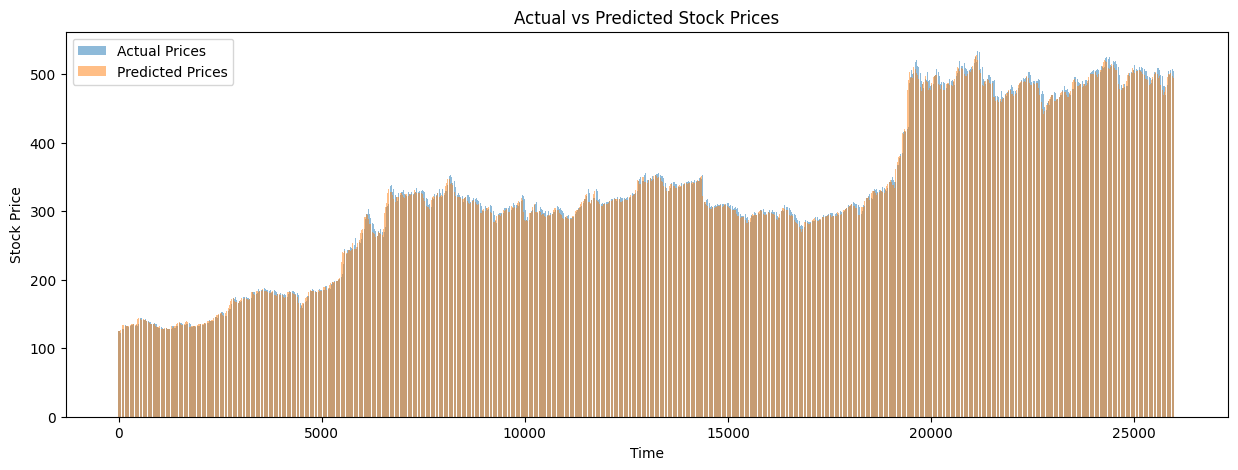

In [11]:
# Plot the actual and predicted stock prices
index = range(min_length)

plt.figure(figsize=(15, 5))
plt.bar(index, y_test_trimmed, label='Actual Prices', alpha=0.5)
plt.bar(index, predictions_trimmed.reshape(-1), label='Predicted Prices', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.title('Actual vs Predicted Stock Prices')
plt.show()

Dataset Size: Our dataset size can be found using the len(df) command. We can report the size of the dataset as well as the sizes of the training and testing sets. In our code, we have used an 80-20 split for training and testing data.

In [ ]:
total_data_size = len(df)
train_data_size = train_data_len
test_data_size = len(df) - train_data_len
print("Total data size: ", total_data_size)
print("Train data size: ", train_data_size)
print("Test data size: ", test_data_size)

Total data size:  130347
Train data size:  104277
Test data size:  26070


In [ ]:
# Get the dates corresponding to the test data
dates_test = df['date'].iloc[-min_length:]

# Create a DataFrame with actual and predicted prices
results_df = pd.DataFrame({'Date': dates_test, 'Actual Prices': y_test_trimmed, 'Predicted Prices': predictions_trimmed.reshape(-1)})
results_df



,Date,Actual Prices,Predicted Prices
104337,2020-09-25 10:00:00+05:30,125.30,125.215340
104338,2020-09-25 10:05:00+05:30,125.50,125.231903
104339,2020-09-25 10:10:00+05:30,125.30,125.152069
104340,2020-09-25 10:15:00+05:30,126.00,125.037216
104341,2020-09-25 10:20:00+05:30,125.85,124.890717
...,...,...,...
130342,2022-02-18 15:05:00+05:30,499.05,491.000458
130343,2022-02-18 15:10:00+05:30,499.40,490.771729
130344,2022-02-18 15:15:00+05:30,499.00,490.578369
130345,2022-02-18 15:20:00+05:30,499.20,490.413300


In [12]:
end_time = time.time()
time_taken = end_time - start_time  # Make sure you subtract the start_time from end_time to get the elapsed time
time_taken_hours = time_taken / 3600
results_df["Time Taken for execution in hours"] = time_taken_hours
print("Time taken:", time_taken_hours, "hours")

Time taken: 21.203844499323104 hours


In [ ]:
!pip install xlsxwriter


In [ ]:
# create an Excel writer object
writer = pd.ExcelWriter('advanced_GRU_DropOut_0pnt5_20epochs_model_TATAMOTORS_stock_prediction_results.xlsx', engine='xlsxwriter')
results_df.to_excel(writer, index=False, sheet_name="results")
writer.save()


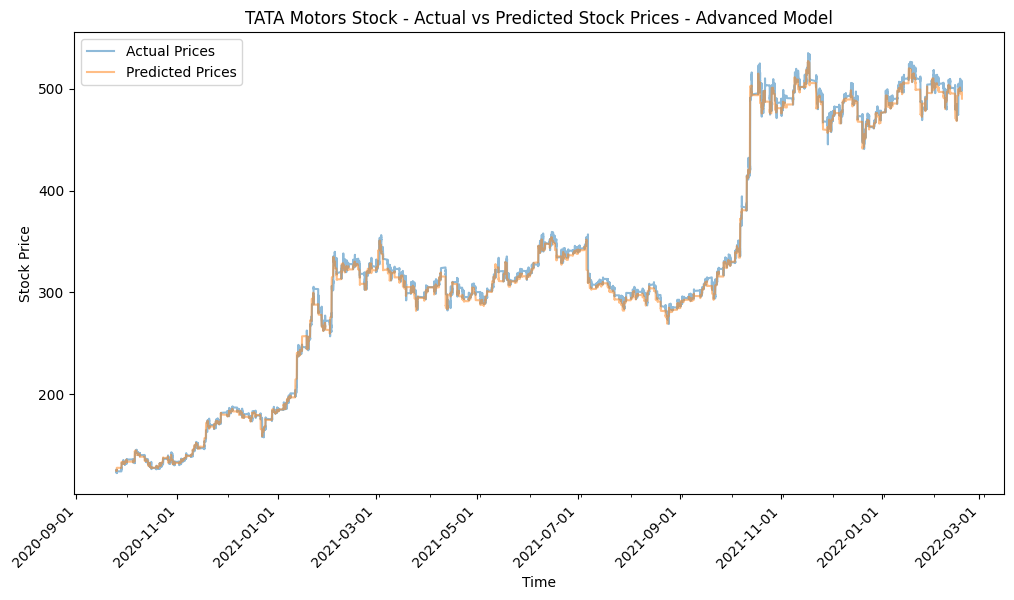

In [10]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import pandas as pd

# Convert the dates to datetime objects
results_df.index = pd.to_datetime(results_df["Date"])

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the actual prices
ax.plot(results_df.index, results_df['Actual Prices'], label='Actual Prices', alpha=0.5)

# Plot the predicted prices
ax.plot(results_df.index, results_df['Predicted Prices'], label='Predicted Prices', alpha=0.5)

# Format x-axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adjust the value '2' to control the number of minor ticks
plt.xticks(rotation=45, ha='right')

# Set the labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_title('TATA Motors Stock - Actual vs Predicted Stock Prices - Advanced Model')
ax.legend()

plt.show()
